In [2]:
import sys, os
import torch
import pandas as pd
import glob
from tqdm import tqdm
from omegaconf import OmegaConf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import datetime
import seaborn as sns
local_user_path = '/home/jq01/git/cleo_jason_working_branch' # change to your own path
sys.path.append(local_user_path) 
from ensemble import Ensemble
from data_util import FragmentDataset


### 241217: Predictions from MLP fragment and sequence models

In [26]:
env_cmd = "source activate /home/jq01/.conda/envs/cleo"
script_name = 'predict.py'
run_prefix = ['fragment_model', 'sequence_model'] #  'esm_model' , 'mpnn_model'

base_path = ['/home/jq01/git/cleo_jason_working_branch/ckpt/241217_train_final_fragment_wo_val_run1/241217_train_final_fragment_wo_val_run1.2024-12-17-13-09-20',
            '/home/jq01/git/cleo_jason_working_branch/ckpt/241217_train_final_sequence_wo_val_run5/241217_train_final_sequence_wo_val_run5.2024-12-17-19-38-09']
  # this is the yaml file name
home_path = '/home/jq01/git/cleo_jason_working_branch'
script_path = os.path.join(home_path, script_name)
cmds_path = os.path.join(home_path, 'cmds')

now = datetime.datetime.now()   
date_str = now.strftime("%y%m%d")

base_config = 'eval_config'  # this is the yaml file name

commands_list = []
for i,j in zip(run_prefix, base_path):
    run_name = f"{date_str}_prediction_{i}"
    cmd = f"python {script_name} -cn {base_config} run_prefix={i} base_path={j}"
    task = f"{env_cmd}; cd {home_path}; {cmd}"
    commands_list.append(task+"\n")

with open(f"{cmds_path}/{date_str}_prediction_tasks", "w") as f:
    f.writelines(commands_list)

commands_list

['source activate /home/jq01/.conda/envs/cleo; cd /home/jq01/git/cleo_jason_working_branch; python predict.py -cn eval_config run_prefix=fragment_model base_path=/home/jq01/git/cleo_jason_working_branch/ckpt/241217_train_final_fragment_wo_val_run1/241217_train_final_fragment_wo_val_run1.2024-12-17-13-09-20\n',
 'source activate /home/jq01/.conda/envs/cleo; cd /home/jq01/git/cleo_jason_working_branch; python predict.py -cn eval_config run_prefix=sequence_model base_path=/home/jq01/git/cleo_jason_working_branch/ckpt/241217_train_final_sequence_wo_val_run5/241217_train_final_sequence_wo_val_run5.2024-12-17-19-38-09\n']

In [30]:
submit_script_content = f"""#!/bin/bash
#SBATCH -p cpu
#SBATCH --mem=16g
#SBATCH -c 1
#SBATCH -o /home/jq01/git/cleo_jason_working_branch/logs/ajob_%j_%a.out
#SBATCH -J {date_str}_prediction
#SBATCH -t 10:00:00

# get line number ${{SLURM_ARRAY_TASK_ID}} from tasks file
CMD=$(sed -n "${{SLURM_ARRAY_TASK_ID}}p" {cmds_path}/{date_str}_prediction_tasks)
# tell bash to run $CMD
echo "${{CMD}}" | bash
"""

submit_script_path = os.path.join(home_path, 'submit', f'{date_str}_prediction_array.sh')

with open(submit_script_path, 'w') as f:
    f.write(submit_script_content)

print(f"Submit scriptt: \nsbatch -a 1-$(cat {cmds_path}/{date_str}_prediction_tasks|wc -l) {submit_script_path}")



Submit scriptt: 
sbatch -a 1-$(cat /home/jq01/git/cleo_jason_working_branch/cmds/241217_prediction_tasks|wc -l) /home/jq01/git/cleo_jason_working_branch/submit/241217_prediction_array.sh


In [5]:
from matplotlib_venn import venn2, venn3

base_path = ['/home/jq01/git/cleo_jason_working_branch/ckpt/241217_train_final_fragment_wo_val_run1/241217_train_final_fragment_wo_val_run1.2024-12-17-13-09-20',
            '/home/jq01/git/cleo_jason_working_branch/ckpt/241217_train_final_sequence_wo_val_run5/241217_train_final_sequence_wo_val_run5.2024-12-17-19-38-09']

In [6]:
df_fragment = pd.read_csv(base_path[0]+'/'+'fragment_model_predictions.csv')
df_sequence = pd.read_csv(base_path[1]+'/'+'sequence_model_predictions.csv')

In [13]:
df_fragment.head()

,name,sequence,raw_rate,cluster_id,cluster_size,has_been_evaluated,z_score_norm_rate,min_max_norm_rate,mu_pred,sigma_pred,ubc_pred
0,frag1_temp0.5num124COMBO:frag2_temp0.5num045:f...,TAAAERVAEVLQATREIAAQVAVNYRAAFQQAYDARDGAALRRVIT...,-inf,0feaca6e,22,False,-inf,-inf,1.066445,0.924383,1.990828
1,frag1_temp0.5num124COMBO:frag2_temp0.5num056:f...,TAAAERVAEVLQATREIAAQVAVNYRAAFQQAYDARDGAALRRVIT...,-inf,0feaca6e,22,False,-inf,-inf,1.023519,0.901381,1.924899
2,frag1_temp0.5num124COMBO:frag2_temp0.2num082:f...,TAAAERVAEVLQATREIAAQVAVNYRAAFQQAYDARDGAALRRVIT...,-inf,0feaca6e,22,False,-inf,-inf,0.874430,0.762365,1.636795
3,frag1_temp0.5num124COMBO:frag2_parent_2:frag3_...,TAAAERVAEVLQATREIAAQVAVNYRAAFQQAYDARDGAALRRVIT...,-inf,0feaca6e,22,False,-inf,-inf,2.438227,1.390165,3.828392
4,frag1_temp0.5num124COMBO:frag2_temp0.2num021CO...,TAAAERVAEVLQATREIAAQVAVNYRAAFQQAYDARDGAALRRVLT...,-inf,0feaca6e,22,False,-inf,-inf,0.525785,0.753131,1.278915


<Axes: xlabel='mu_pred', ylabel='Density'>

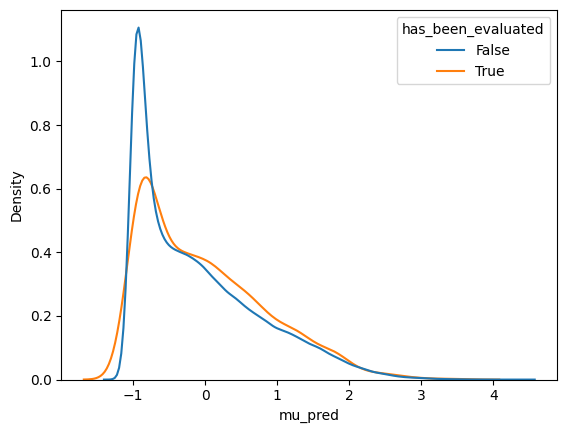

In [18]:
sns.kdeplot(data=df_fragment, x='mu_pred', hue='has_been_evaluated', common_norm=False)

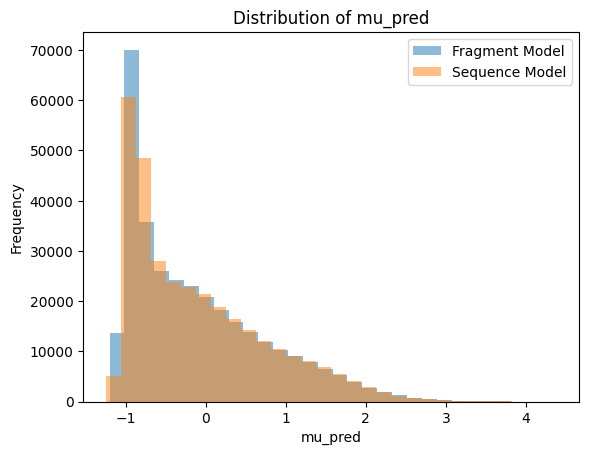

In [7]:
# Visual exploration: Histograms of mu_pred
plt.hist(df_fragment['mu_pred'], bins=30, alpha=0.5, label='Fragment Model')
plt.hist(df_sequence['mu_pred'], bins=30, alpha=0.5, label='Sequence Model')
plt.xlabel('mu_pred')
plt.ylabel('Frequency')
plt.title('Distribution of mu_pred')
plt.legend()
plt.show()

/home/jq01/.conda/envs/cleo/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


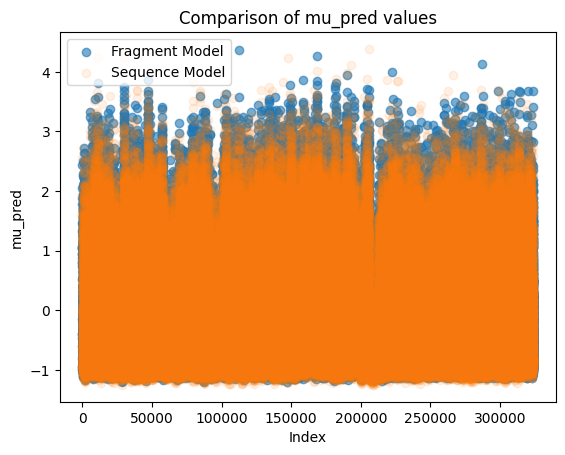

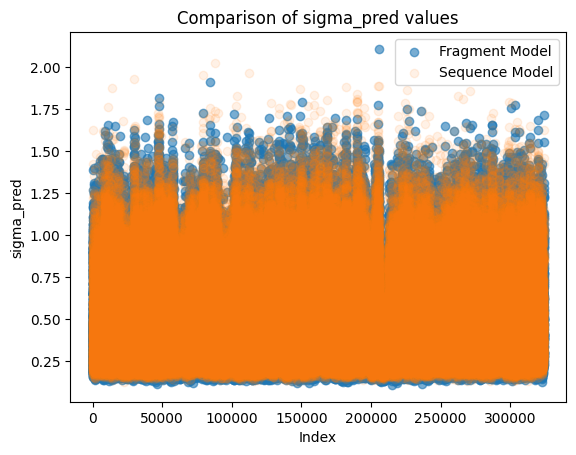

In [12]:
#Scatter plot to compare mu_pred and sigma_pred
def scatter_plot_comparison(df1, df2, column, label1, label2):
    plt.scatter(range(len(df1)), df1[column], alpha=0.6, label=label1)
    plt.scatter(range(len(df2)), df2[column], alpha=0.1, label=label2)
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.title(f'Comparison of {column} values')
    plt.legend()
    plt.show()

scatter_plot_comparison(df_fragment, df_sequence, 'mu_pred', 'Fragment Model', 'Sequence Model')
scatter_plot_comparison(df_fragment, df_sequence, 'sigma_pred', 'Fragment Model', 'Sequence Model')

/tmp/ipykernel_200507/1006134111.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_fragment['mu_pred'], df_sequence['mu_pred']], labels=['Fragment Model', 'Sequence Model'])


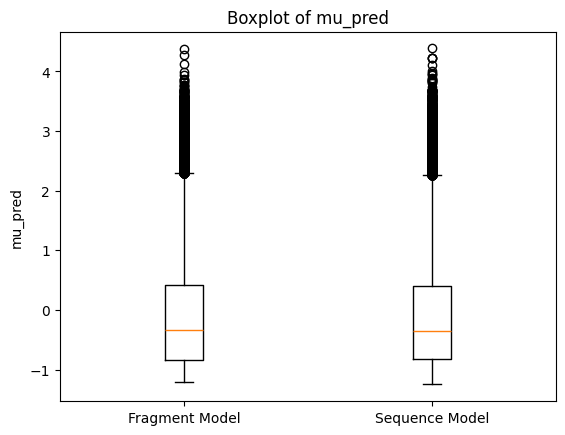

In [42]:
# Boxplot comparison for mu_pred and sigma_pred
plt.boxplot([df_fragment['mu_pred'], df_sequence['mu_pred']], labels=['Fragment Model', 'Sequence Model'])
plt.ylabel('mu_pred')
plt.title('Boxplot of mu_pred')
plt.show()

/tmp/ipykernel_200507/3006459548.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_fragment['sigma_pred'], df_sequence['sigma_pred']], labels=['Fragment Model', 'Sequence Model'])


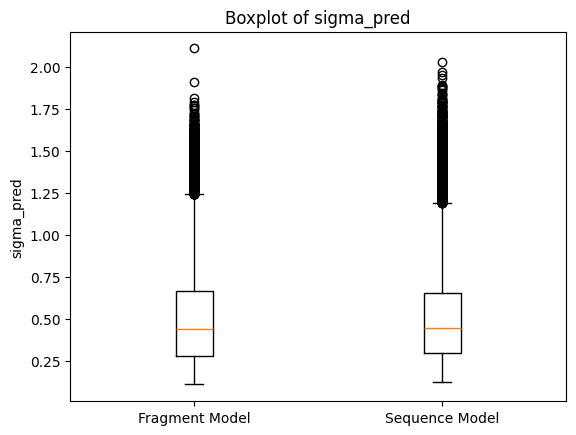

In [44]:
plt.boxplot([df_fragment['sigma_pred'], df_sequence['sigma_pred']], labels=['Fragment Model', 'Sequence Model'])
plt.ylabel('sigma_pred')
plt.title('Boxplot of sigma_pred')
plt.show()

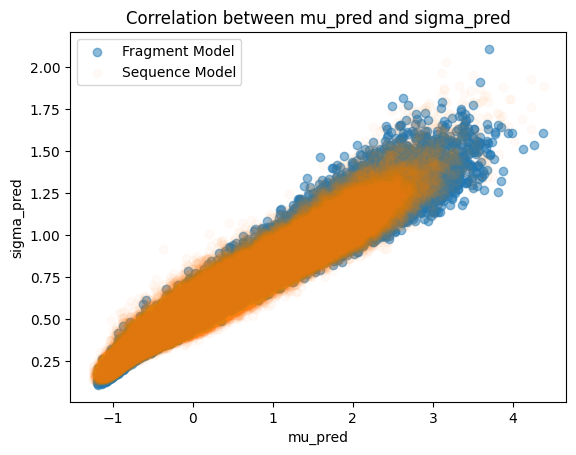

In [19]:
# Correlation analysis between mu_pred and sigma_pred
plt.scatter(df_fragment['mu_pred'], df_fragment['sigma_pred'], alpha=0.5, label='Fragment Model')
plt.scatter(df_sequence['mu_pred'], df_sequence['sigma_pred'], alpha=0.03, label='Sequence Model')
plt.xlabel('mu_pred')
plt.ylabel('sigma_pred')
plt.title('Correlation between mu_pred and sigma_pred')
plt.legend()
plt.show()


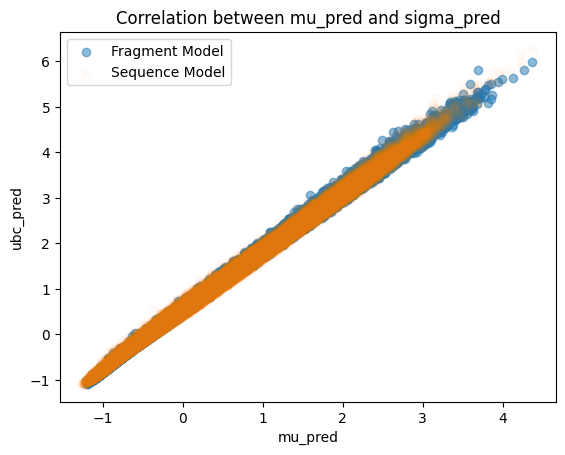

In [20]:
# Correlation analysis between mu_pred and sigma_pred
plt.scatter(df_fragment['mu_pred'], df_fragment['ubc_pred'], alpha=0.5, label='Fragment Model')
plt.scatter(df_sequence['mu_pred'], df_sequence['ubc_pred'], alpha=0.03, label='Sequence Model')
plt.xlabel('mu_pred')
plt.ylabel('ubc_pred')
plt.title('Correlation between mu_pred and sigma_pred')
plt.legend()
plt.show()


In [32]:
# Select top 100 rows based on descending mu_pred and ubc_pred
top_number = 1000
top_fragment_mu = df_fragment.nlargest(top_number, 'mu_pred')
top_sequence_mu = df_sequence.nlargest(top_number, 'mu_pred')

top_fragment_ubc = df_fragment.nlargest(top_number, 'ubc_pred')
top_sequence_ubc = df_sequence.nlargest(top_number, 'ubc_pred')

top_fragment_mu = df_fragment.nlargest(top_number, 'mu_pred')
top_fragment_mu.head()
 


,name,sequence,raw_rate,cluster_id,cluster_size,has_been_evaluated,z_score_norm_rate,min_max_norm_rate,mu_pred,sigma_pred,ubc_pred
112224,frag1_temp0.2num054:frag2_parent_2:frag3_temp0...,SEDDKLVEKVLNATREIARQHAVGYRDDFLAAWRARDGAGLRRVIT...,-inf,4ffc1803,9,False,-inf,-inf,4.371306,1.608465,5.979771
168436,frag1_temp0.5num090:frag2_parent_2:frag3_temp0...,SPEDARVARVLAATREIARREAEGFREDFLRAYAARDGAALRRVIT...,-inf,359c560c,3408,False,-inf,-inf,4.268075,1.534980,5.803055
286881,frag1_temp0.5num090:frag2_parent_2:frag3_temp0...,SPEDARVARVLAATREIARREAEGFREDFLRAYAARDGAALRRVIT...,-inf,8d0f5c21,16,False,-inf,-inf,4.127740,1.511620,5.639360
222688,frag1_temp0.2num054:frag2_parent_2:frag3_temp0...,SEDDKLVEKVLNATREIARQHAVGYRDDFLAAWRARDGAGLRRVIT...,-inf,8f3ed274,32,False,-inf,-inf,3.993714,1.610239,5.603953
190245,frag1_temp0.2num054:frag2_parent_2:frag3_temp0...,SEDDKLVEKVLNATREIARQHAVGYRDDFLAAWRARDGAGLRRVIT...,-inf,fe939d39,16,False,-inf,-inf,3.943796,1.608763,5.552559


In [33]:
top_fragment_mu.tail()

,name,sequence,raw_rate,cluster_id,cluster_size,has_been_evaluated,z_score_norm_rate,min_max_norm_rate,mu_pred,sigma_pred,ubc_pred
131267,frag1_temp0.2num018:frag2_temp0.2num069:frag3_...,SEDQVLVDKVLEATRRIAEEEAVAYKDDFLKAYNARDGAGLRRVIT...,-inf,3629ba06,19,False,-inf,-inf,2.717575,1.275398,3.992973
238635,frag1_temp0.2num054:frag2_temp0.5num045:frag3_...,SEDDKLVEKVLNATREIARQHAVGYRDDFLAAWRARDGAGLRRVIT...,-inf,50c12189,16,False,-inf,-inf,2.717242,1.509552,4.226794
261799,frag1_temp0.2num018:frag2_temp0.2num098:frag3_...,SEDQVLVDKVLEATRRIAEEEAVAYKDDFLKAYNARDGAGLRRVIT...,-inf,6c727bce,20,False,-inf,-inf,2.716773,1.348838,4.065610
181885,frag1_temp0.2num054:frag2_parent_2:frag3_temp0...,SEDDKLVEKVLNATREIARQHAVGYRDDFLAAWRARDGAGLRRVIT...,-inf,df7ffdf6,24,False,-inf,-inf,2.716495,1.451527,4.168022
222686,frag1_temp0.2num054:frag2_temp0.2num107COMBO:f...,SEDDKLVEKVLNATREIARQHAVGYRDDFLAAWRARDGAGLRRVLT...,-inf,8f3ed274,32,False,-inf,-inf,2.716226,1.233252,3.949478


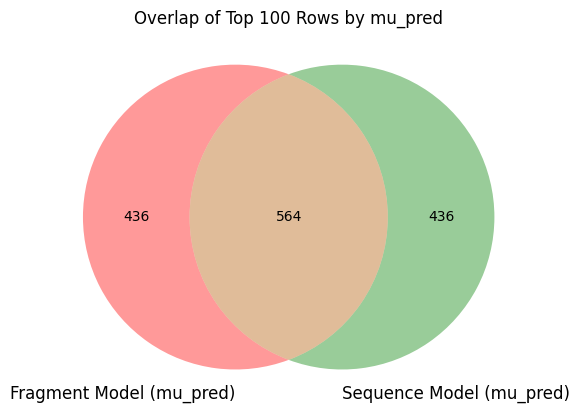

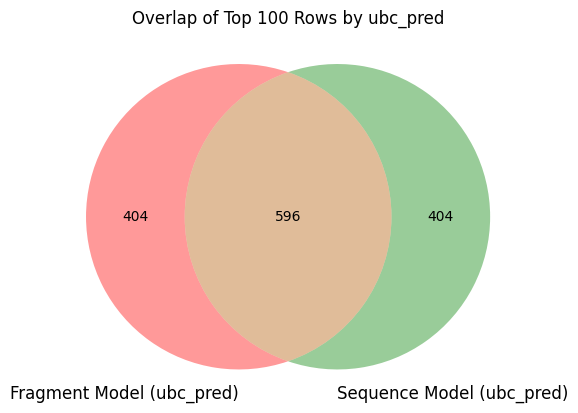

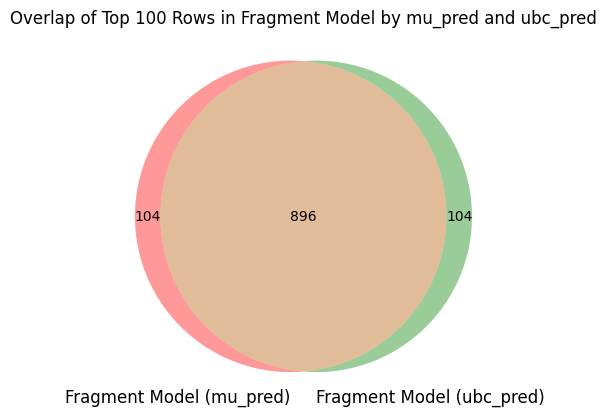

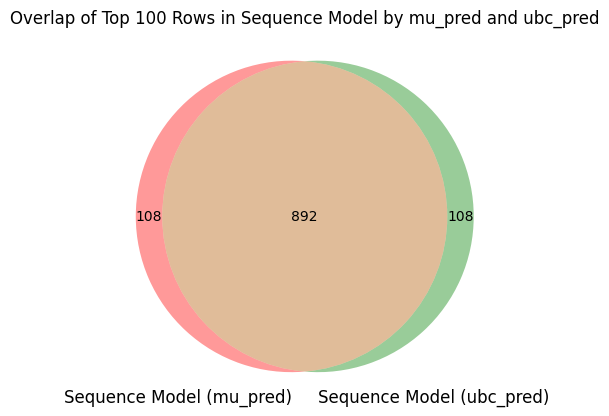

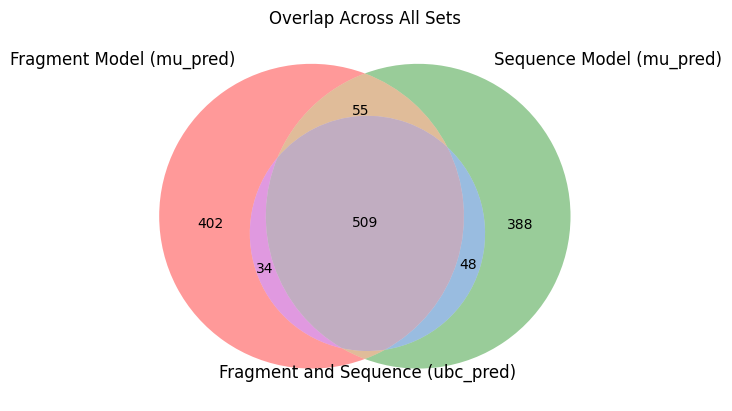

Number of overlapping names for mu_pred: 564
Overlapping names for mu_pred: {'frag1_temp0.5num121:frag2_temp0.2num100:frag3_temp0.5num058:frag4_temp0.2num070COMBO', 'frag1_temp0.5num115:frag2_parent_2:frag3_temp0.2num100:frag4_temp0.2num070COMBO', 'frag1_temp0.2num066COMBO:frag2_parent_2:frag3_temp0.5num058:frag4_temp0.2num071COMBO', 'frag1_temp0.5num115:frag2_temp0.2num100:frag3_temp0.5num058:frag4_temp0.5num071', 'frag1_parent_1:frag2_parent_2:frag3_temp0.5num058:frag4_temp0.2num013COMBO', 'frag1_temp0.2num054COMBO:frag2_parent_2:frag3_temp0.2num100:frag4_temp0.5num121', 'frag1_temp0.2num032:frag2_parent_2:frag3_temp0.5num120:frag4_temp0.2num070COMBO', 'frag1_temp0.2num054:frag2_temp0.2num098:frag3_temp0.5num058:frag4_temp0.5num030', 'frag1_temp0.5num115:frag2_parent_2:frag3_temp0.2num100:frag4_temp0.2num016COMBO', 'frag1_temp0.2num066COMBO:frag2_parent_2:frag3_temp0.5num058:frag4_temp0.5num030', 'frag1_parent_1:frag2_parent_2:frag3_temp0.2num100:frag4_temp0.2num013COMBO', 'frag1_tem

In [22]:
# Find the overlap based on 'name' column for mu_pred
fragment_mu_names = set(top_fragment_mu['name'])
sequence_mu_names = set(top_sequence_mu['name'])
overlap_mu = fragment_mu_names & sequence_mu_names

# Find the overlap based on 'name' column for ubc_pred
fragment_ubc_names = set(top_fragment_ubc['name'])
sequence_ubc_names = set(top_sequence_ubc['name'])
overlap_ubc = fragment_ubc_names & sequence_ubc_names

# Find the overlap within fragment model for mu_pred and ubc_pred
fragment_overlap_mu_ubc = fragment_mu_names & fragment_ubc_names

# Find the overlap within sequence model for mu_pred and ubc_pred
sequence_overlap_mu_ubc = sequence_mu_names & sequence_ubc_names

# Find the overlap across all four sets
all_overlap = fragment_mu_names & sequence_mu_names & fragment_ubc_names & sequence_ubc_names

# Create a DataFrame from the designs in all_overlap
df_all_overlap = pd.DataFrame({'name': list(all_overlap)})
df_all_overlap = df_all_overlap.merge(df_fragment, on='name', how='inner', suffixes=('_frag', '_seq'))
df_all_overlap = df_all_overlap.merge(df_sequence, on='name', how='inner', suffixes=('_frag', '_seq'))

# Plot Venn diagram for mu_pred
venn2([fragment_mu_names, sequence_mu_names], ('Fragment Model (mu_pred)', 'Sequence Model (mu_pred)'))
plt.title('Overlap of Top 100 Rows by mu_pred')
plt.show()

# Plot Venn diagram for ubc_pred
venn2([fragment_ubc_names, sequence_ubc_names], ('Fragment Model (ubc_pred)', 'Sequence Model (ubc_pred)'))
plt.title('Overlap of Top 100 Rows by ubc_pred')
plt.show()

# Plot Venn diagram for fragment model overlap (mu_pred vs ubc_pred)
venn2([fragment_mu_names, fragment_ubc_names], ('Fragment Model (mu_pred)', 'Fragment Model (ubc_pred)'))
plt.title('Overlap of Top 100 Rows in Fragment Model by mu_pred and ubc_pred')
plt.show()

# Plot Venn diagram for sequence model overlap (mu_pred vs ubc_pred)
venn2([sequence_mu_names, sequence_ubc_names], ('Sequence Model (mu_pred)', 'Sequence Model (ubc_pred)'))
plt.title('Overlap of Top 100 Rows in Sequence Model by mu_pred and ubc_pred')
plt.show()

# Plot Venn diagram for overlap across all four sets
venn3([fragment_mu_names, sequence_mu_names, fragment_ubc_names & sequence_ubc_names],
      ('Fragment Model (mu_pred)', 'Sequence Model (mu_pred)', 'Fragment and Sequence (ubc_pred)'))
plt.title('Overlap Across All Sets')
plt.show()

print(f"Number of overlapping names for mu_pred: {len(overlap_mu)}")
print("Overlapping names for mu_pred:", overlap_mu)

print(f"Number of overlapping names for ubc_pred: {len(overlap_ubc)}")
print("Overlapping names for ubc_pred:", overlap_ubc)

print(f"Number of overlapping names within Fragment Model (mu_pred vs ubc_pred): {len(fragment_overlap_mu_ubc)}")
print("Overlapping names within Fragment Model (mu_pred vs ubc_pred):", fragment_overlap_mu_ubc)

print(f"Number of overlapping names within Sequence Model (mu_pred vs ubc_pred): {len(sequence_overlap_mu_ubc)}")
print("Overlapping names within Sequence Model (mu_pred vs ubc_pred):", sequence_overlap_mu_ubc)

print(f"Number of overlapping names across all sets: {len(all_overlap)}")
print("Overlapping names across all sets:", all_overlap)



In [34]:
df_all_overlap

,name,sequence_frag,raw_rate_frag,cluster_id_frag,cluster_size_frag,has_been_evaluated_frag,z_score_norm_rate_frag,min_max_norm_rate_frag,mu_pred_frag,sigma_pred_frag,...,sequence_seq,raw_rate_seq,cluster_id_seq,cluster_size_seq,has_been_evaluated_seq,z_score_norm_rate_seq,min_max_norm_rate_seq,mu_pred_seq,sigma_pred_seq,ubc_pred_seq
0,frag1_temp0.5num121:frag2_temp0.2num100:frag3_...,TADEERVRKVLESTREIAKKHAVKYTDAFLAAYKARDGAGLRRVIT...,-inf,16f91023,120,False,-inf,-inf,2.999907,1.375830,...,TADEERVRKVLESTREIAKKHAVKYTDAFLAAYKARDGAGLRRVIT...,-inf,16f91023,120,False,-inf,-inf,3.068783,1.220503,4.289285
1,frag1_temp0.5num115:frag2_parent_2:frag3_temp0...,SDDQVRVEDVLRATREIAKEVGQSFQAAFAEAYDARDGAALRRVIT...,-inf,818c9027,11,False,-inf,-inf,3.594377,1.581859,...,SDDQVRVEDVLRATREIAKEVGQSFQAAFAEAYDARDGAALRRVIT...,-inf,818c9027,11,False,-inf,-inf,3.070132,1.653520,4.723652
2,frag1_temp0.5num115:frag2_temp0.2num100:frag3_...,SDDQVRVEDVLRATREIAKEVGQSFQAAFAEAYDARDGAALRRVIT...,-inf,16af1806,27718,False,-inf,-inf,2.920648,1.619926,...,SDDQVRVEDVLRATREIAKEVGQSFQAAFAEAYDARDGAALRRVIT...,-inf,16af1806,27718,False,-inf,-inf,2.892580,1.344770,4.237349
3,frag1_parent_1:frag2_parent_2:frag3_temp0.5num...,SENEKLVEKVLEATRRIAREEAVKYKDAFLRAYRARDGAGLRRVIT...,-inf,7a9616c6,1362,False,-inf,-inf,2.897058,1.727327,...,SENEKLVEKVLEATRRIAREEAVKYKDAFLRAYRARDGAGLRRVIT...,-inf,7a9616c6,1362,False,-inf,-inf,3.832625,1.720024,5.552649
4,frag1_temp0.2num032:frag2_parent_2:frag3_temp0...,TEDEVRVQRVLDATREIARREAVAYKDAFLEAYRARDGAGLRRVIT...,-inf,197dcdd0,2380,False,-inf,-inf,2.848609,1.537640,...,TEDEVRVQRVLDATREIARREAVAYKDAFLEAYRARDGAGLRRVIT...,-inf,197dcdd0,2380,False,-inf,-inf,2.920841,1.311345,4.232185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,frag1_temp0.2num054COMBO:frag2_parent_2:frag3_...,SEDDVLVEKVLKATEEIAKEKAEAYKDAFLAAYNARDGAGLRRVIT...,-inf,a766e0fb,13,False,-inf,-inf,2.904754,1.287692,...,SEDDVLVEKVLKATEEIAKEKAEAYKDAFLAAYNARDGAGLRRVIT...,-inf,a766e0fb,13,False,-inf,-inf,2.709124,1.379137,4.088261
505,frag1_temp0.5num103COMBO:frag2_temp0.2num100:f...,TEDDRRVATVLAATRAIAREVAQDYKDAFLQAFEARDGAALRRVIT...,-inf,6e88f000,17,False,-inf,-inf,2.927453,1.370458,...,TEDDRRVATVLAATRAIAREVAQDYKDAFLQAFEARDGAALRRVIT...,-inf,6e88f000,17,False,-inf,-inf,2.710228,1.323538,4.033766
506,frag1_temp0.2num054:frag2_temp0.2num060:frag3_...,SEDDKLVEKVLNATREIARQHAVGYRDDFLAAWRARDGAGLRRVLT...,-inf,fe939d39,16,False,-inf,-inf,2.974733,1.444041,...,SEDDKLVEKVLNATREIARQHAVGYRDDFLAAWRARDGAGLRRVLT...,-inf,fe939d39,16,False,-inf,-inf,3.054868,1.363906,4.418773
507,frag1_parent_1:frag2_temp0.2num100:frag3_temp0...,SENEKLVEKVLEATRRIAREEAVKYKDAFLRAYRARDGAGLRRVIT...,-inf,63942a4f,2039,False,-inf,-inf,3.281901,1.348804,...,SENEKLVEKVLEATRRIAREEAVKYKDAFLRAYRARDGAGLRRVIT...,-inf,63942a4f,2039,False,-inf,-inf,3.185033,1.417579,4.602612
